# Installs & Imports

In [1]:
!pip install -q dask[dataframe]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
from scipy import stats
from scipy.special import inv_boxcox
import warnings

warnings.filterwarnings("ignore")

# Seaborn style for plots
sns.set(style="whitegrid")

# Data Loading

In [3]:
def load_dataset():
    """
    Load the CO₂ dataset from statsmodels, rename column to 'value', drop missing values,
    and convert index to datetime.
    """
    data = sm.datasets.co2.load_pandas().data
    data = data.rename(columns={'co2': 'value'})
    data = data.dropna()
    data.index = pd.to_datetime(data.index)
    return data

# Load data
data = load_dataset()
print("=== DATASET PREVIEW ===")
display(data.head())
print(f"\nDataset Shape: {data.shape}")

=== DATASET PREVIEW ===


,value
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4



Dataset Shape: (2225, 1)


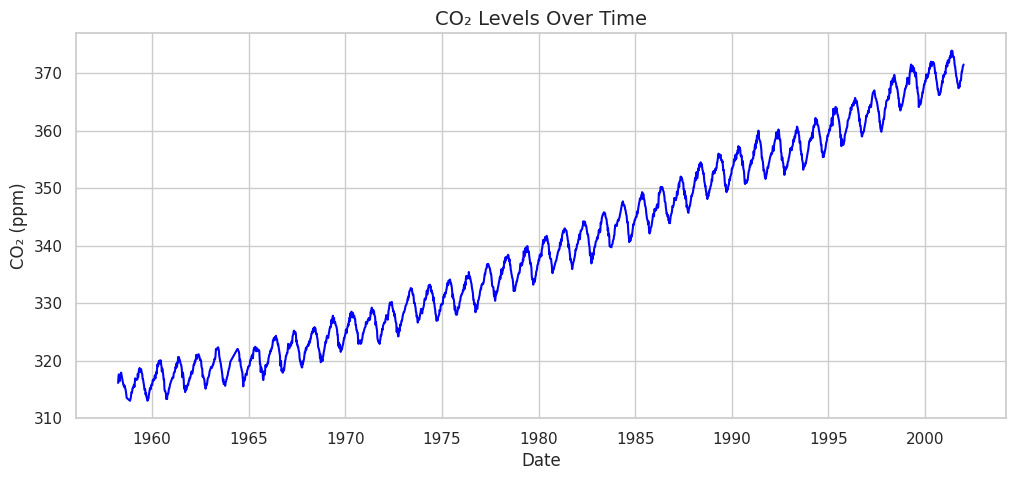

In [4]:
def visualize_time_series(data, title="CO₂ Concentrations"):
    """
    Plot the time series data for a quick overview.
    """
    plt.figure(figsize=(12,5))
    plt.plot(data.index, data['value'], color='blue')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("CO₂ (ppm)", fontsize=12)
    plt.show()

# Visualization
visualize_time_series(data, title="CO₂ Levels Over Time")

# Data Exploration

In [5]:
def perform_stationarity_tests(series):
    """
    Perform ADF and KPSS tests on a time series and print results.

    Parameters:
    - series: pandas Series to be tested for stationarity
    """
    print("\n=== ADF Test ===")
    adf_res = adfuller(series, autolag='AIC')
    adf_keys = ['Test Statistic','p-value','#Lags Used','Obs Used']
    adf_output = pd.Series(adf_res[0:4], index=adf_keys)
    for key, val in adf_res[4].items():
        adf_output[f"CV ({key})"] = val
    print(adf_output)

    print("\n=== KPSS Test ===")
    kpss_res = kpss(series, regression='c')
    kpss_keys = ['Test Statistic','p-value','Lags Used']
    kpss_output = pd.Series(kpss_res[0:3], index=kpss_keys)
    for key, val in kpss_res[3].items():
        kpss_output[f"CV ({key})"] = val
    print(kpss_output)

# Perform stationarity tests
perform_stationarity_tests(data['value'])


=== ADF Test ===
Test Statistic       0.043965
p-value              0.962020
#Lags Used          27.000000
Obs Used          2197.000000
CV (1%)             -3.433330
CV (5%)             -2.862856
CV (10%)            -2.567471
dtype: float64

=== KPSS Test ===
Test Statistic     7.464953
p-value            0.010000
Lags Used         29.000000
CV (10%)           0.347000
CV (5%)            0.463000
CV (2.5%)          0.574000
CV (1%)            0.739000
dtype: float64


# Data Splitting

In [6]:
def split_data(df, train_ratio=0.8):
    """
    Split the data into train/test sets based on train_ratio.

    Parameters:
    - df: pandas DataFrame
    - train_ratio: ratio of data to use for training (default=0.8)

    Returns:
    - train_df: training DataFrame
    - test_df: testing DataFrame
    """
    if not 0 < train_ratio < 1:
        raise ValueError("train_ratio must be between 0 and 1.")
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df

train, test = split_data(data, train_ratio=0.8)
print("=== DATA SPLIT ===")
print(f"Train size: {train.shape[0]}, Test size: {test.shape[0]}")

=== DATA SPLIT ===
Train size: 1780, Test size: 445


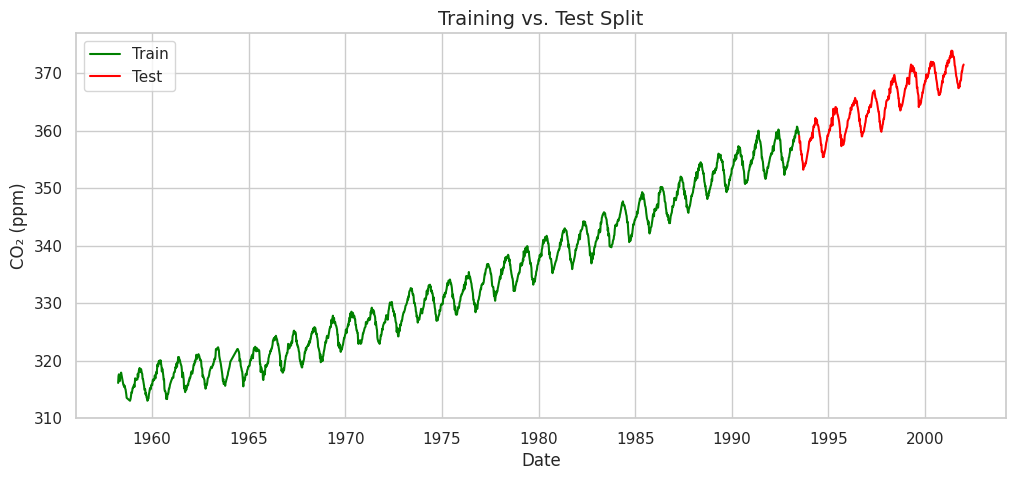

In [7]:
def visualize_splits(train_df, test_df, title="Training vs. Test Split"):
    """
    Visualize how the data is split into training and test sets.

    Parameters:
    - train_df: training DataFrame
    - test_df: testing DataFrame
    - title: title for the plot (default="Training vs. Test Split")
    """
    plt.figure(figsize=(12,5))
    plt.plot(train_df.index, train_df['value'], label='Train', color='green')
    plt.plot(test_df.index, test_df['value'], label='Test', color='red')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("CO₂ (ppm)", fontsize=12)
    plt.legend()
    plt.show()

visualize_splits(train, test)

# Data Transformation

In [8]:
def fit_transform(train_series, method='box-cox'):
    """
    Fit and apply Box-Cox or Log transform on the training data.
    Returns transformed data, lam (if boxcox), original_min, and shift.

    Parameters:
    - train_series: pandas Series to be transformed
    - method: transformation method ('box-cox' or 'log')

    Returns:
    - transformed_train: pandas Series of transformed training data
    - lam: lambda parameter for Box-Cox (if applicable)
    - original_min: minimum value before transformation
    - shift: shift applied during transformation
    """
    original_min = train_series.min()
    shift = 1 - original_min if original_min <= 0 else 0
    shifted_train = train_series + shift

    if method == 'box-cox':
        transformed_train, lam = stats.boxcox(shifted_train)
        transformed_train = pd.Series(transformed_train, index=train_series.index)
        return transformed_train, lam, original_min, shift
    elif method == 'log':
        transformed_train = np.log(shifted_train)
        transformed_train = pd.Series(transformed_train, index=train_series.index)
        return transformed_train, None, original_min, shift
    else:
        raise ValueError("method must be 'box-cox' or 'log'.")

def apply_transform(test_series, method='box-cox', lam=None, shift=0):
    """
    Apply the previously fitted transform parameters to the test data.

    Parameters:
    - test_series: pandas Series to be transformed
    - method: transformation method ('box-cox' or 'log')
    - lam: lambda parameter for Box-Cox
    - shift: shift applied during transformation

    Returns:
    - transformed_test: pandas Series of transformed test data
    """
    shifted_test = test_series + shift

    if method == 'box-cox':
        if lam is None:
            raise ValueError("Lambda is required for Box-Cox.")
        # Ensure all shifted_test values are positive
        if (shifted_test <= 0).any():
            raise ValueError("All values must be positive after shifting for Box-Cox.")
        transformed_test = stats.boxcox(shifted_test, lmbda=lam)
        transformed_test = pd.Series(transformed_test, index=test_series.index)
        return transformed_test
    elif method == 'log':
        # Ensure all shifted_test values are positive
        if (shifted_test <= 0).any():
            raise ValueError("All values must be positive after shifting for Log transform.")
        transformed_test = np.log(shifted_test)
        transformed_test = pd.Series(transformed_test, index=test_series.index)
        return transformed_test
    else:
        raise ValueError("method must be 'box-cox' or 'log'.")

def inverse_transform(transformed_series, method='box-cox', lam=None, shift=0):
    """
    Inverse transform the data back to original scale.

    Parameters:
    - transformed_series: pandas Series of transformed data
    - method: transformation method ('box-cox' or 'log')
    - lam: lambda parameter for Box-Cox
    - shift: shift applied during transformation

    Returns:
    - inv_transformed: pandas Series of inverse transformed data
    """
    if method == 'box-cox':
        if lam is None:
            raise ValueError("Lambda is required for inverse Box-Cox.")
        inv_transformed = inv_boxcox(transformed_series, lam)
        inv_transformed = inv_transformed - shift
        return inv_transformed
    elif method == 'log':
        inv_transformed = np.exp(transformed_series) - shift
        return inv_transformed
    else:
        raise ValueError("method must be 'box-cox' or 'log'.")

=== Data Transformation: box-cox ===
Training data transformed successfully.
Test data transformed successfully.



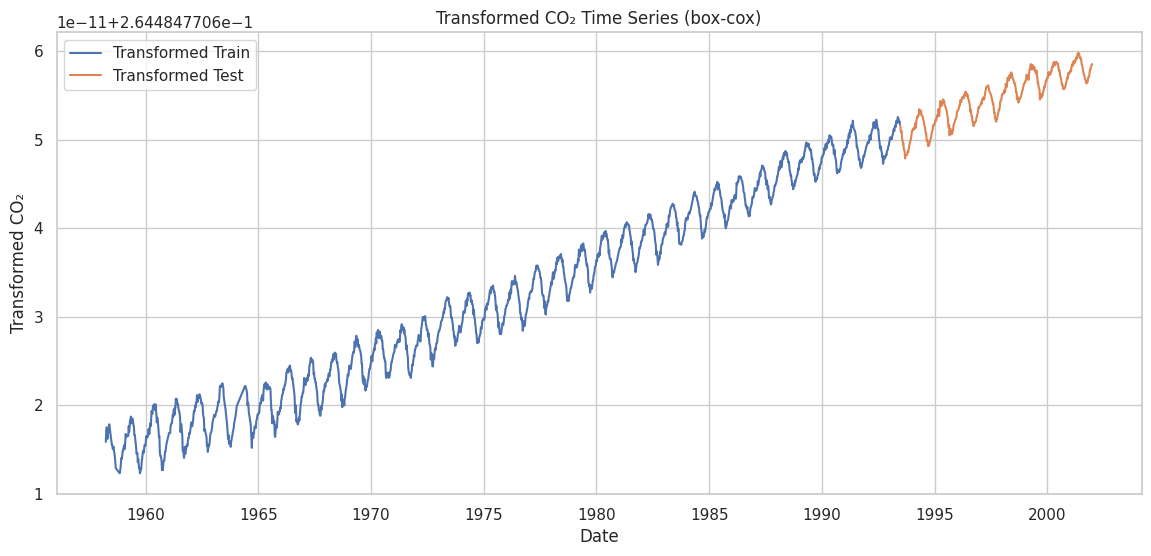

In [9]:
# Choose transformation method: 'box-cox' or 'log' or None
TRANSFORMATION = 'box-cox'

if TRANSFORMATION:
    # Fit and transform the training data
    transformed_train, lam, original_min, shift = fit_transform(train['value'], method=TRANSFORMATION)

    # Apply the same transformation to the test data
    transformed_test = apply_transform(test['value'], method=TRANSFORMATION, lam=lam, shift=shift)

    # Create DataFrames for the transformed data
    transformed_train_df = pd.DataFrame({'value': transformed_train}, index=train.index)
    transformed_test_df = pd.DataFrame({'value': transformed_test}, index=test.index)

    print(f"=== Data Transformation: {TRANSFORMATION} ===")
    print("Training data transformed successfully.")
    print("Test data transformed successfully.\n")

    # Plot transformed data
    plt.figure(figsize=(14, 6))
    plt.plot(transformed_train_df, label='Transformed Train')
    plt.plot(transformed_test_df, label='Transformed Test')
    plt.title(f'Transformed CO₂ Time Series ({TRANSFORMATION})')
    plt.xlabel('Date')
    plt.ylabel('Transformed CO₂')
    plt.legend()
    plt.show()
else:
    # If no transformation, use original data
    transformed_train_df = train.copy()
    transformed_test_df = test.copy()
    print("=== No Data Transformation Applied ===")

# Detrending

In [10]:
def differencing_detrend(df_train, df_test):
    """
    First-order differencing for train and test sets.
    Adjusts the first differenced test value to ensure continuity.

    Parameters:
    - df_train: pandas DataFrame with 'value' column for training data
    - df_test: pandas DataFrame with 'value' column for testing data

    Returns:
    - train_diff: pandas Series of differenced training data
    - test_diff: pandas Series of differenced testing data
    """
    # First-order differencing on training data
    train_diff = df_train['value'].diff().dropna()

    # Calculate the differenced value for the first test point
    last_train_val = df_train['value'].iloc[-1]
    first_test_val = df_test['value'].iloc[0]
    first_test_diff = first_test_val - last_train_val

    # Differencing on test data
    test_diff = df_test['value'].diff().dropna()

    if not test_diff.empty:
        test_diff.iloc[0] = first_test_diff

    return train_diff, test_diff

In [11]:
def seasonal_differencing_detrend(df_train, df_test, s=12):
    """
    Seasonal differencing with period s for train and test sets.

    Parameters:
    - df_train: pandas DataFrame with 'value' column for training data
    - df_test: pandas DataFrame with 'value' column for testing data
    - s: seasonal period (default=12)

    Returns:
    - train_sdiff: pandas Series of seasonally differenced training data
    - test_sdiff: pandas Series of seasonally differenced testing data
    """
    # Seasonal differencing on training data
    train_sdiff = df_train['value'].diff(s).dropna()

    # Concatenate train and test for seasonal differencing to ensure continuity
    combined = pd.concat([df_train['value'], df_test['value']])
    full_sdiff = combined.diff(s)

    # Extract the seasonally differenced test data
    test_sdiff = full_sdiff.iloc[len(df_train):].dropna()

    return train_sdiff, test_sdiff

In [12]:
def regression_detrend(df_train, df_test, model_type='linear'):
    """
    Remove trend by fitting linear/polynomial regression to train,
    then subtracting from train data and applying to test data.

    Parameters:
    - df_train: pandas DataFrame with 'value' column for training data
    - df_test: pandas DataFrame with 'value' column for testing data
    - model_type: type of regression model ('linear' or 'polynomial')

    Returns:
    - detr_train: pandas Series of detrended training data
    - detr_test: pandas Series of detrended testing data
    - trend_test: pandas Series of trend values for the test data
    """
    t_train = np.arange(len(df_train)).reshape(-1,1)
    t_test = np.arange(len(df_train), len(df_train)+len(df_test)).reshape(-1,1)

    if model_type == 'linear':
        model = LinearRegression()
        model.fit(t_train, df_train['value'])
        trend_train = model.predict(t_train)
        trend_test = model.predict(t_test)
    elif model_type == 'polynomial':
        poly = PolynomialFeatures(degree=2)
        t_train_poly = poly.fit_transform(t_train)
        t_test_poly = poly.transform(t_test)
        model = LinearRegression()
        model.fit(t_train_poly, df_train['value'])
        trend_train = model.predict(t_train_poly)
        trend_test = model.predict(t_test_poly)
    else:
        raise ValueError("model_type must be 'linear' or 'polynomial'.")

    detr_train = df_train['value'] - trend_train
    detr_test = df_test['value'] - trend_test

    # Convert trend_test to pandas Series with the same index as df_test
    trend_test_series = pd.Series(trend_test, index=df_test.index)

    return detr_train, detr_test, trend_test_series

In [13]:
# Define parameters
LAGS = [1, 2, 3, 4, 5]
K_FOURIER = 3
S_PERIOD = 12

In [14]:
# Initialize dictionaries to store detrended data and trends
detrended_data = {}
trend_data = {}

In [15]:
# (1) First-Order Differencing
diff_train, diff_test = differencing_detrend(transformed_train_df, transformed_test_df)
detrended_data['Differenced'] = {
    'train': diff_train,
    'test': diff_test
}

In [16]:
# (2) Seasonal Differencing
sdiff_train, sdiff_test = seasonal_differencing_detrend(transformed_train_df, transformed_test_df, s=S_PERIOD)
detrended_data['Seasonally Differenced'] = {
    'train': sdiff_train,
    'test': sdiff_test
}

In [17]:
# (3) Regression Detrending (Linear)
lin_detr_train, lin_detr_test, lin_trend_test = regression_detrend(
    transformed_train_df, transformed_test_df, model_type='linear'
)
detrended_data['Regression Detrended (Linear)'] = {
    'train': lin_detr_train,
    'test': lin_detr_test
}
trend_data['Regression Detrended (Linear)'] = lin_trend_test

In [18]:
# (4) Regression Detrending (Polynomial)
poly_detr_train, poly_detr_test, poly_trend_test = regression_detrend(
    transformed_train_df, transformed_test_df, model_type='polynomial'
)
detrended_data['Regression Detrended (Polynomial)'] = {
    'train': poly_detr_train,
    'test': poly_detr_test
}
trend_data['Regression Detrended (Polynomial)'] = poly_trend_test

# Feature Engineering

In [19]:
def add_fourier_terms(df, period=12, K=3):
    """
    Add sine/cosine Fourier terms for capturing seasonality.

    Parameters:
    - df: pandas DataFrame
    - period: seasonal period (default=12)
    - K: number of Fourier terms (default=3)

    Returns:
    - df: pandas DataFrame with added Fourier terms
    """
    t = np.arange(len(df))
    for k in range(1, K + 1):
        df[f'sin_{k}'] = np.sin((2 * np.pi * k * t) / period)
        df[f'cos_{k}'] = np.cos((2 * np.pi * k * t) / period)
    return df

def add_lags(df, lags=[1, 2]):
    """
    Add lagged versions of the 'value' column for capturing autocorrelation.

    Parameters:
    - df: pandas DataFrame
    - lags: list of lag periods (default=[1,2])

    Returns:
    - df: pandas DataFrame with added lag features
    """
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)
    return df

def prepare_features(series, lags=[1, 2, 3, 4, 5], period=12, K=3):
    """
    Combine Fourier terms and lagged features in a single DataFrame.
    The input 'series' should be a pandas Series of the target data (detrended/differenced).

    Parameters:
    - series: pandas Series
    - lags: list of lag periods (default=[1,2,3,4,5])
    - period: seasonal period for Fourier terms (default=12)
    - K: number of Fourier terms (default=3)

    Returns:
    - df: pandas DataFrame with features
    """
    df = pd.DataFrame({'value': series.values}, index=series.index)
    df = add_fourier_terms(df, period=period, K=K)
    df = add_lags(df, lags=lags)
    df.dropna(inplace=True)
    return df

In [20]:
# Initialize dictionaries to store feature sets
feature_sets = {}
target_sets = {}
test_target_sets = {}

In [21]:
for method, data_dict in detrended_data.items():
    print(f"Processing Feature Preparation for: {method}")

    # Prepare training features
    train_df = prepare_features(
        data_dict['train'], lags=LAGS, period=S_PERIOD, K=K_FOURIER
    )
    X_train = train_df.drop(columns=['value'])
    y_train = train_df['value']

    # Prepare testing features
    test_df = prepare_features(
        data_dict['test'], lags=LAGS, period=S_PERIOD, K=K_FOURIER
    )
    X_test = test_df.drop(columns=['value'])
    y_test = test_df['value']

    # Store in dictionaries
    feature_sets[method] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

Processing Feature Preparation for: Differenced
Processing Feature Preparation for: Seasonally Differenced
Processing Feature Preparation for: Regression Detrended (Linear)
Processing Feature Preparation for: Regression Detrended (Polynomial)


In [22]:
print("=== Prepared Feature Sets ===")
for method, features in feature_sets.items():
    print(f"- {method}:")
    print(f"  - Training Samples: {features['X_train'].shape[0]}")
    print(f"  - Testing Samples: {features['X_test'].shape[0]}")

=== Prepared Feature Sets ===
- Differenced:
  - Training Samples: 1774
  - Testing Samples: 439
- Seasonally Differenced:
  - Training Samples: 1763
  - Testing Samples: 440
- Regression Detrended (Linear):
  - Training Samples: 1775
  - Testing Samples: 440
- Regression Detrended (Polynomial):
  - Training Samples: 1775
  - Testing Samples: 440


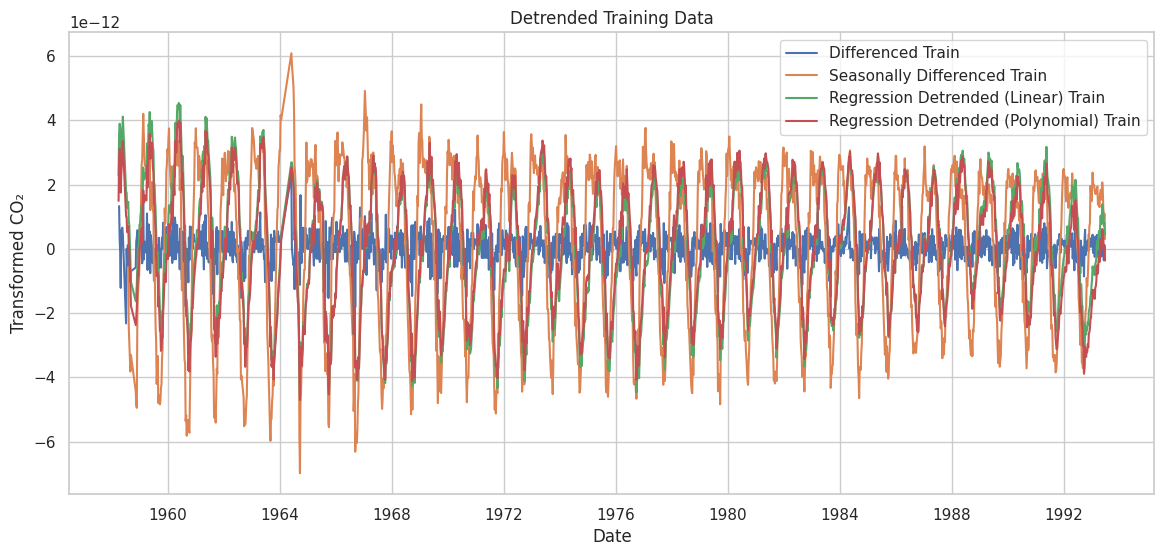

In [23]:
# Plot the detrended data
plt.figure(figsize=(14, 6))
plt.plot(detrended_data['Differenced']['train'], label='Differenced Train')
plt.plot(detrended_data['Seasonally Differenced']['train'], label='Seasonally Differenced Train')
plt.plot(detrended_data['Regression Detrended (Linear)']['train'], label='Regression Detrended (Linear) Train')
plt.plot(detrended_data['Regression Detrended (Polynomial)']['train'], label='Regression Detrended (Polynomial) Train')
plt.title('Detrended Training Data')
plt.xlabel('Date')
plt.ylabel('Transformed CO₂')
plt.legend()
plt.show()

# Model Training

In [24]:
def train_predict_lgbm(X_train, y_train, X_test, num_boost_round=100):
    """
    Train a LightGBM model and return predictions for X_test.

    Parameters:
    - X_train: training features
    - y_train: training target
    - X_test: testing features
    - num_boost_round: number of boosting rounds (default=100)

    Returns:
    - predictions
    """
    train_data = lgb.Dataset(X_train, label=y_train)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'seed': 123
    }
    model = lgb.train(params, train_data, num_boost_round=num_boost_round)
    predictions = model.predict(X_test)
    return predictions

In [25]:
# Get predictions for each detrending method
pred_diff = train_predict_lgbm(
    feature_sets['Differenced']['X_train'],
    feature_sets['Differenced']['y_train'],
    feature_sets['Differenced']['X_test']
)

pred_sdiff = train_predict_lgbm(
    feature_sets['Seasonally Differenced']['X_train'],
    feature_sets['Seasonally Differenced']['y_train'],
    feature_sets['Seasonally Differenced']['X_test']
)

pred_lin = train_predict_lgbm(
    feature_sets['Regression Detrended (Linear)']['X_train'],
    feature_sets['Regression Detrended (Linear)']['y_train'],
    feature_sets['Regression Detrended (Linear)']['X_test']
)

pred_poly = train_predict_lgbm(
    feature_sets['Regression Detrended (Polynomial)']['X_train'],
    feature_sets['Regression Detrended (Polynomial)']['y_train'],
    feature_sets['Regression Detrended (Polynomial)']['X_test']
)

# Post-Processing

In [26]:
# Define the maximum lag used in feature engineering
MAX_LAG = 5

In [27]:
def reconstruct_diff(pred, last_train_val, method, lam, shift):
    """
    Reconstruct from differenced predictions.

    Parameters:
    - pred: numpy array of predictions (shape: [n_samples])
    - last_train_val: float, last value of the training set before differencing
    - method: transformation method ('box-cox' or 'log')
    - lam: lambda parameter for Box-Cox
    - shift: shift applied during transformation

    Returns:
    - recon: numpy array of reconstructed predictions in original scale
    """
    recon = np.cumsum(pred) + last_train_val
    recon = inverse_transform(recon, method=method, lam=lam, shift=shift)
    return recon

In [28]:
def reconstruct_sdiff(pred, combined_trans, train_len, s=12, method='box-cox', lam=None, shift=0):
    """
    Reconstruct from seasonal differencing.
    Add each pred to the value s steps behind in combined_trans.

    Parameters:
    - pred: numpy array of predictions (shape: [n_samples])
    - combined_trans: pandas Series of combined transformed train and test data
    - train_len: int, length of the training set
    - s: seasonal period (default=12)
    - method: transformation method ('box-cox' or 'log')
    - lam: lambda parameter for Box-Cox
    - shift: shift applied during transformation

    Returns:
    - recon: numpy array of reconstructed predictions in original scale
    """
    recon = []
    for i, xhat in enumerate(pred):
        idx = train_len + i
        if idx - s >= 0:
            val_s = combined_trans.iloc[idx - s]
            recon.append(xhat + val_s)
        else:
            # Handle cases where idx - s < 0 if necessary
            recon.append(xhat)
    recon = np.array(recon)
    recon = inverse_transform(recon, method=method, lam=lam, shift=shift)
    return recon

In [29]:
def reconstruct_lin(pred_detr, test_trend, method, lam, shift, max_lag=5):
    """
    Reconstruct from regression-based detrending: add the trend, inverse transform.

    Parameters:
    - pred_detr: numpy array of predictions (shape: [n_samples])
    - test_trend: pandas Series of trend values (shape: [n_samples + max_lag])
    - method: transformation method ('box-cox' or 'log')
    - lam: lambda parameter for Box-Cox
    - shift: shift applied during transformation
    - max_lag: maximum lag used in feature engineering

    Returns:
    - recon_lin: numpy array of reconstructed predictions in original scale
    """
    # Slice the trend to align with predictions
    aligned_trend = test_trend.iloc[max_lag:].values  # Shape: [n_samples]

    # Ensure the lengths match
    if len(pred_detr) != len(aligned_trend):
        raise ValueError(f"Length mismatch: pred_detr={len(pred_detr)}, aligned_trend={len(aligned_trend)}")

    # Add the trend to the predictions
    recon_lin = pred_detr + aligned_trend

    # Inverse transform to original scale
    recon_lin = inverse_transform(recon_lin, method=method, lam=lam, shift=shift)

    return recon_lin

In [30]:
# (1) Differencing
last_train_val = transformed_train_df['value'].iloc[-1]
pred_diff_orig = reconstruct_diff(pred_diff, last_train_val, TRANSFORMATION, lam, shift)

In [31]:
# (2) Seasonal Differencing
comb_trans = pd.concat([transformed_train_df['value'], transformed_test_df['value']])
pred_sdiff_orig = reconstruct_sdiff(
    pred_sdiff,
    comb_trans,
    len(transformed_train_df),
    s=12,
    method=TRANSFORMATION,
    lam=lam,
    shift=shift
)

In [32]:
# (3) Regression Detrended (Linear)
pred_lin_orig = reconstruct_lin(
    pred_lin,
    lin_trend_test,
    TRANSFORMATION,
    lam,
    shift,
    max_lag=MAX_LAG
)

In [33]:
# (4) Regression Detrended (Polynomial)
pred_poly_orig = reconstruct_lin(
    pred_poly,
    poly_trend_test,
    TRANSFORMATION,
    lam,
    shift,
    max_lag=MAX_LAG
)

In [34]:
# Validation for Regression Detrended (Linear)
if len(pred_lin_orig) > 0:
    # Compare the first few reconstructed predictions with expected values
    print("First 5 Reconstructed Predictions (Linear):")
    print(pred_lin_orig[:5])

    print("First 5 Actual Values:")
    print(test['value'].iloc[:5].values)

First 5 Reconstructed Predictions (Linear):
[355.81468626 355.90070228 354.72817718 354.81289849 354.86301074]
First 5 Actual Values:
[359.1 357.9 358.  358.1 356.6]


# Performance Evaluation

In [35]:
def plot_reconstruction(actual, predicted, title):
    """
    Plot the actual values and reconstructed predictions.

    Parameters:
    - actual: numpy array of actual values
    - predicted: numpy array of reconstructed values
    - title: string, title of the plot
    """
    plt.figure(figsize=(14, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue')
    plt.plot(actual.index, predicted, label='Predicted', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('CO₂ (ppm)')
    plt.legend()
    plt.show()

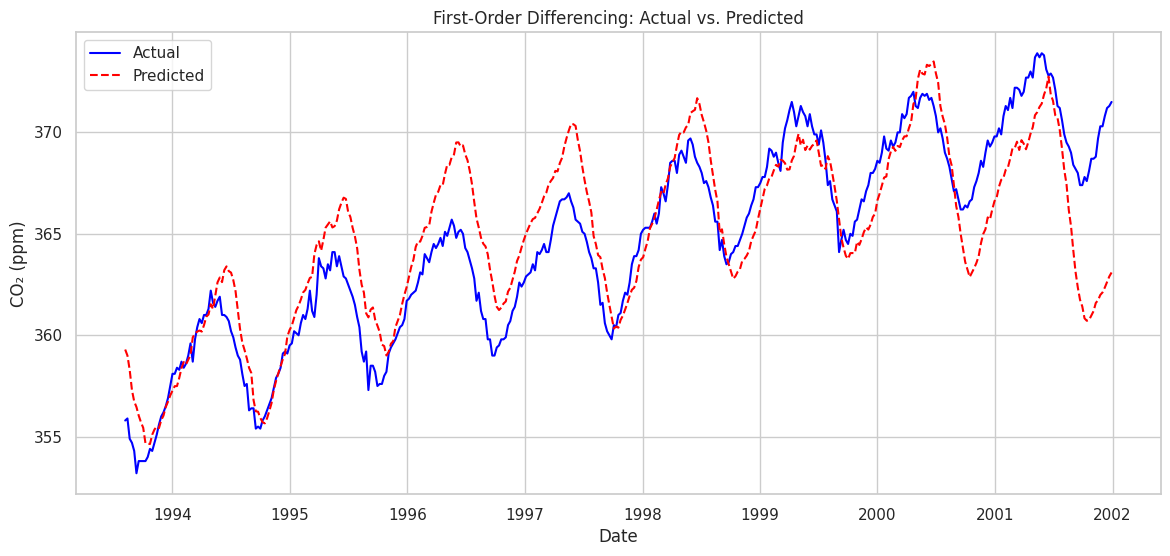

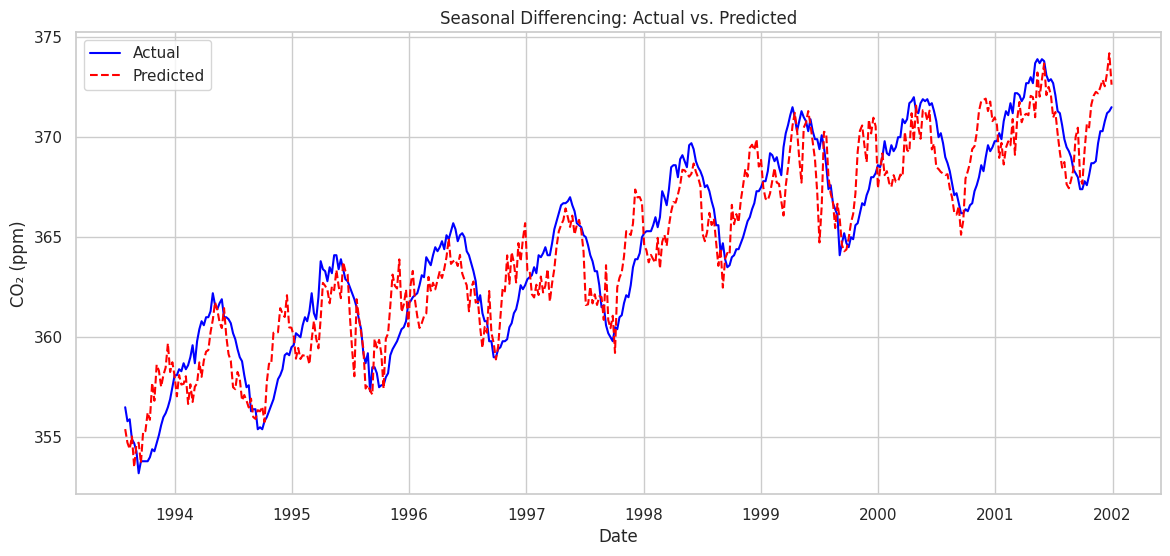

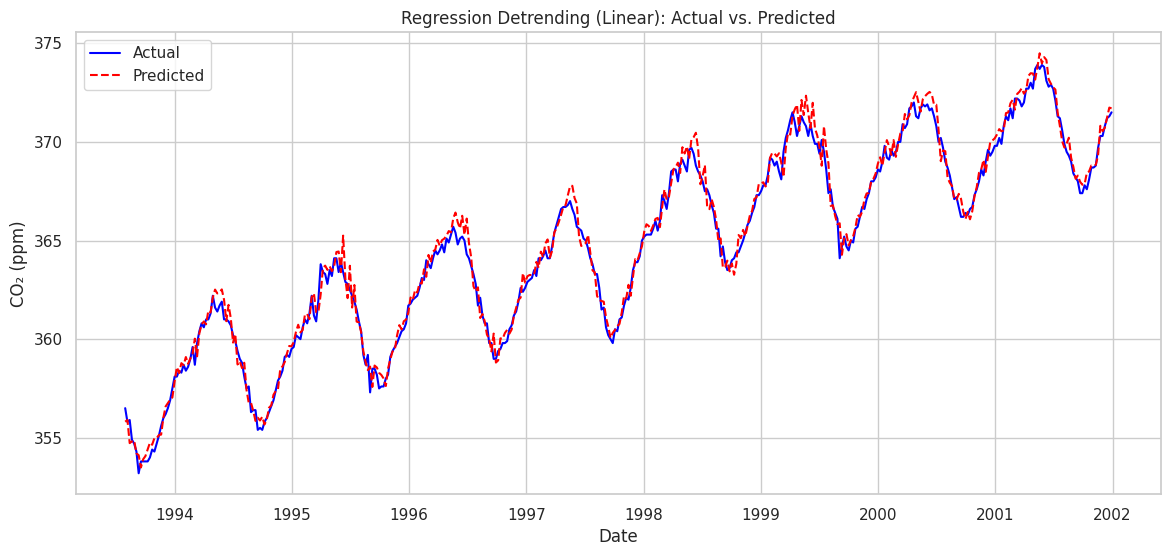

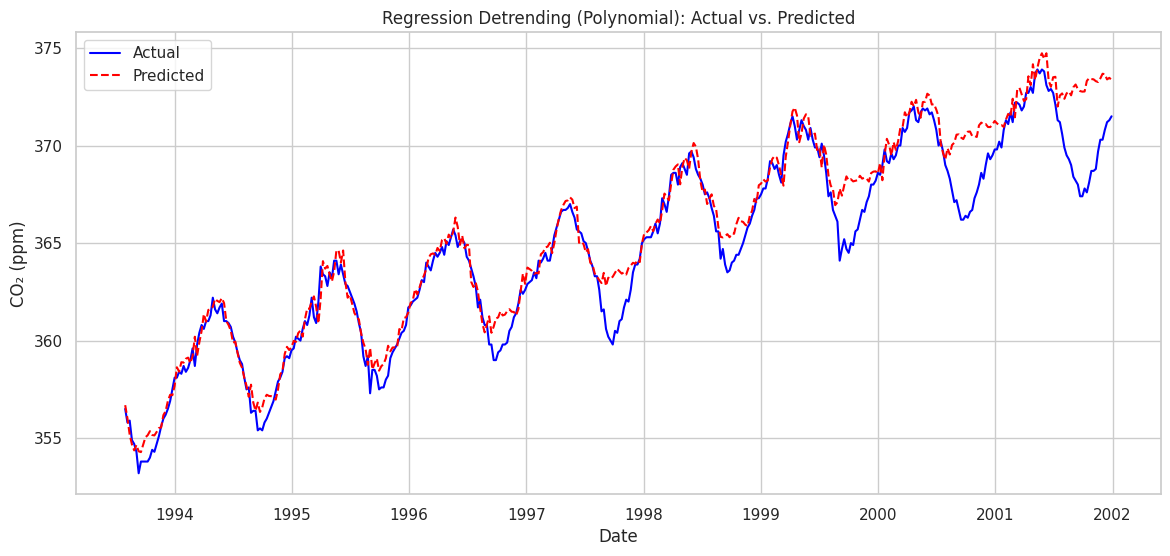

In [36]:
# (1) Differencing
if len(pred_diff_orig) > 0:
    actual_diff = test['value'].iloc[-len(pred_diff_orig):].values
    actual_diff_series = pd.Series(actual_diff, index=test.index[-len(pred_diff_orig):])
    pred_diff_series = pd.Series(pred_diff_orig, index=test.index[-len(pred_diff_orig):])
    plot_reconstruction(actual_diff_series, pred_diff_series, 'First-Order Differencing: Actual vs. Predicted')
    print("\n")

# (2) Seasonal Differencing
if len(pred_sdiff_orig) > 0:
    actual_sdiff = test['value'].iloc[-len(pred_sdiff_orig):].values
    actual_sdiff_series = pd.Series(actual_sdiff, index=test.index[-len(pred_sdiff_orig):])
    sdiff_orig_series = pd.Series(pred_sdiff_orig, index=test.index[-len(pred_sdiff_orig):])
    plot_reconstruction(actual_sdiff_series, sdiff_orig_series, 'Seasonal Differencing: Actual vs. Predicted')
    print("\n")

# (3) Regression Detrended (Linear)
if len(pred_lin_orig) > 0:
    actual_lin = test['value'].iloc[-len(pred_lin_orig):].values
    actual_lin_series = pd.Series(actual_lin, index=test.index[-len(pred_lin_orig):])
    pred_lin_orig_series = pd.Series(pred_lin_orig, index=test.index[-len(pred_lin_orig):])
    plot_reconstruction(actual_lin_series, pred_lin_orig_series, 'Regression Detrending (Linear): Actual vs. Predicted')
    print("\n")

# (4) Regression Detrended (Polynomial)
if len(pred_poly_orig) > 0:
    actual_poly = test['value'].iloc[-len(pred_poly_orig):].values
    actual_poly_series = pd.Series(actual_poly, index=test.index[-len(pred_poly_orig):])
    pred_poly_orig_series = pd.Series(pred_poly_orig, index=test.index[-len(pred_poly_orig):])
    plot_reconstruction(actual_poly_series, pred_poly_orig_series, 'Regression Detrending (Polynomial): Actual vs. Predicted')

In [37]:
def compute_metrics(actual, predicted):
    """
    Compute RMSE, MAE, and MAPE metrics for the predictions.

    Parameters:
    - actual: numpy array of actual values
    - predicted: numpy array of predicted values

    Returns:
    - dict: dictionary containing RMSE, MAE, and MAPE metrics
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [38]:
def evaluate_predictions(
    test_df,
    pred_diff_orig,
    pred_sdiff_orig,
    pred_lin_orig,
    pred_poly_orig
):
    """
    Evaluate each method's predictions that have been reconstructed to original scale.

    Parameters:
    - test_df: pandas DataFrame with the original test data
    - pred_diff_orig: numpy array of reconstructed predictions for Differencing
    - pred_sdiff_orig: numpy array of reconstructed predictions for Seasonal Differencing
    - pred_lin_orig: numpy array of reconstructed predictions for Regression Detrending (Linear)
    - pred_poly_orig: numpy array of reconstructed predictions for Regression Detrending (Polynomial)

    Returns:
    - results_df: pandas DataFrame with evaluation metrics for each method
    """
    results = {}

    # (1) Differencing
    align_len = len(pred_diff_orig)
    actual_diff = test_df['value'].iloc[-align_len:]
    metrics_diff = compute_metrics(actual_diff, pred_diff_orig)
    results['First-Order Differencing'] = metrics_diff

    # (2) Seasonal Differencing
    align_len_s = len(pred_sdiff_orig)
    actual_sdiff = test_df['value'].iloc[-align_len_s:]
    metrics_sdiff = compute_metrics(actual_sdiff, pred_sdiff_orig)
    results['Seasonal Differencing'] = metrics_sdiff

    # (3) Regression (Linear)
    align_len_lin = len(pred_lin_orig)
    actual_lin = test_df['value'].iloc[-align_len_lin:]
    metrics_lin = compute_metrics(actual_lin, pred_lin_orig)
    results['Regression Detrending (Linear)'] = metrics_lin

    # (4) Regression (Polynomial)
    align_len_poly = len(pred_poly_orig)
    actual_poly = test_df['value'].iloc[-align_len_poly:]
    metrics_poly = compute_metrics(actual_poly, pred_poly_orig)
    results['Regression Detrending (Polynomial)'] = metrics_poly

    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Method'
    results_df.reset_index(inplace=True)

    return results_df

metrics_df = evaluate_predictions(test, pred_diff_orig, pred_sdiff_orig, pred_lin_orig, pred_poly_orig)
print("=== Evaluation Metrics ===")
display(metrics_df)

=== Evaluation Metrics ===


,Method,RMSE,MAE,MAPE
0,First-Order Differencing,2.503351,1.952013,0.534099
1,Seasonal Differencing,1.815294,1.539524,0.422389
2,Regression Detrending (Linear),0.574398,0.450747,0.123480
3,Regression Detrending (Polynomial),1.476516,0.972215,0.266092
